In [18]:
"""
The OS module in Python provides a way of using operating system dependent functionality.
"""
import os
import urllib.request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union, List 


class Agros:
    """
    A class for downloading and processing agricultural data.
    """

    def __init__(self):
        """
        Initializes the Agros class.
        """
        self.url = "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv"
        self.filename = "Agricultural total factor productivity (USDA).csv"
        self.download_dir = os.path.join(os.getcwd(), "downloads")
        self.download_path = os.path.join(self.download_dir, self.filename)
        self.dataset = None

    def download_data(self):
        """
        Downloads data from a given URL and saves it to a specified file path.

        Returns:
            pandas.DataFrame: The downloaded dataset.
        """
        if os.path.isfile(self.download_path):
            print("Data file already exists, skipping download...")
            self.dataset = pd.read_csv(
                "downloads/Agricultural total factor productivity (USDA).csv"
            )
            return self.dataset

        if not os.path.exists(self.download_dir):
            os.makedirs(self.download_dir)
            print(f"Created directory: {self.download_dir}")

        print(f"Downloading data file from {self.url}...")
        urllib.request.urlretrieve(self.url, self.download_path)

        print(f"Data file downloaded and saved to {self.download_path}")
        self.dataset = pd.read_csv(
            "downloads/Agricultural total factor productivity (USDA).csv"
        )
        return self.dataset

    def get_countries(self):
        """
        Returns a list of available countries in the dataset.

        Returns
        -------
        list
            A list of strings representing the available countries in the dataset.
        """
        if self.dataset is None:
            self.download_data()

        return list(self.dataset["Entity"].unique())

    def plot_correlation(self):

        """
        Plots a heatmap of the correlations between the specified columns.

        Parameters
        ----------
        columns : list of str
            A list of strings representing the columns to include in the correlation analysis.

        Returns
        -------
        None
            This function has no return value.
        """

        if self.dataset is None:
            self.download_data()

        columns = [
            "output_quantity",
            "crop_output_quantity",
            "animal_output_quantity",
            "fish_output_quantity",
            "ag_land_quantity",
            "labor_quantity",
            "capital_quantity",
            "machinery_quantity",
            "livestock_quantity",
            "fertilizer_quantity",
            "animal_feed_quantity",
            "cropland_quantity",
            "pasture_quantity",
            "irrigation_quantity",
        ]

        corr = self.dataset[columns].corr()
        sns.heatmap(corr, cmap="coolwarm", annot=True)

    def areachart_country_output(self, country='World', normalize=False):

        """
        Plots an area chart of the  "\_output_" columns for a given country

        Parameters
        ---------------
        country: string
            Country selected to plot area chart of the outputs, if *NONE* or 'World' should plot the sum for all *distinct* countries
        normalize: boolean
            If True, normalizes the output in relative terms: each year, output should always be 100%

        Raises
        -------
            ValueError(f'{country} is not a valid')

        Returns
        -------
            Area Chart: This function returns area chart with outputs of a country by year

        """
        if self.dataset is None:
            self.download_data()

        # Load data
        data = self.dataset

        df = data.filter(regex="_output_|Year|Entity")

        # Filter by country if specified
        if country is not None:
            if country.lower() == "world" or country is None:
                df = df.groupby("Year").sum().reset_index()
            else:
                df = df[df["Entity"] == country.capitalize()]
                if df.empty:
                    raise ValueError(f"{country} is not a valid")
                df = df.drop("Entity", axis=1)

        # Normalize if specified
        if normalize:
            df.iloc[:, 1:] = (
                df.iloc[:, 1:].div(df.iloc[:, 1:].sum(axis=1), axis=0).multiply(100)
            )

        # Plot an area chart for the output columns
        sns.set_theme(palette="bright")
        plt.stackplot(
            df["Year"], df.iloc[:, 1:].values.T, labels=df.iloc[:, 1:].columns
        )
        plt.legend()
        plt.xlabel("Year")
        plt.title(
            f'Agricultural Outputs {"for " + country if country else "All Countries"}'
        )
        plt.show()

    def compare_country_output(self, countries):

        """
        Compare the total output for a (list of) countries for every year in the dataset and plot the results.

        Parameters:
        countries (str or list of str): A string or list of strings representing the countries to compare

        Raises:
        TypeError: If the countries argument is not a string or list of strings
        ValueError: If the countries argument is an empty list

        Returns:
        None
        """

        if self.dataset is None:
            self.download_data()

        # Filter the DataFrame to include only the selected countries
        if isinstance(countries, str):
            countries = [countries]

        file = self.dataset[self.dataset["Entity"].isin(countries)]

        # Group the data by year and sum the output values for each year
        df_grouped = file.groupby("Year")["output"].sum()

        # Plot the results using Matplotlib
        plt.plot(df_grouped.index, df_grouped.values)
        plt.xlabel("Year")
        plt.ylabel("Total output")
        plt.title("Comparison of total output for {}".format(", ".join(countries)))
        plt.show()  

    def plot_country_output(self, countries):
        
        if self.dataset is None:
            self.download_data()
            
        data = self.dataset
        
        if isinstance(countries, str):
            countries = [countries]

        fig, ax = plt.subplots()
        for country in countries:
            country_data = data[data["Entity"] == country]
            ax.plot(country_data["Year"], country_data["output"], label=country)

        ax.legend()
        ax.set_xlabel("Year")
        ax.set_ylabel("Output")
        ax.set_title("Comparison of Total Output by Country")

        plt.show()

 

    def gapminder(self, year):
        
        """
        Creates a scatter plot of fertilizer quantity vs. output quantity for a specific year in the Gapminder dataset, where the area of each dot represents the TFP (total factor productivity) for the respective year.
    
        Parameters
        ----------
        year : int
            The year for which to create the scatter plot.
    
        Raises
        ------
        TypeError
            If the year argument is not an integer.
    
        Returns
        -------
        None
    
        Notes
        -----
        This method assumes that the dataset has already been downloaded and loaded into a pandas DataFrame with columns "Year", "fertilizer_quantity", "output_quantity", and "tfp". If these columns are not present, an error will be raised.
        """

        if self.dataset is None:
            self.download_data()

        # Check that the year argument is an int
        if not isinstance(year, int):
            raise TypeError("Year argument must be an integer.")

        # Load the gapminder dataset into a pandas DataFrame
        df = self.dataset

        # Filter the DataFrame to include only the selected year
        df_year = df[df["Year"] == year]

        # Create a scatter plot of fertilizer quantity vs. output quantity
        plt.scatter(
            df_year["fertilizer_quantity"], df_year["output_quantity"], s=df_year["tfp"]
        )
        plt.xlabel("Fertilizer quantity")
        plt.ylabel("Output quantity")
        plt.xscale("log")
        plt.yscale("log")
        plt.title("Evolvement of TFP for the year {}".format(year))
        plt.show()


In [19]:
laura = Agros()

Data file already exists, skipping download...


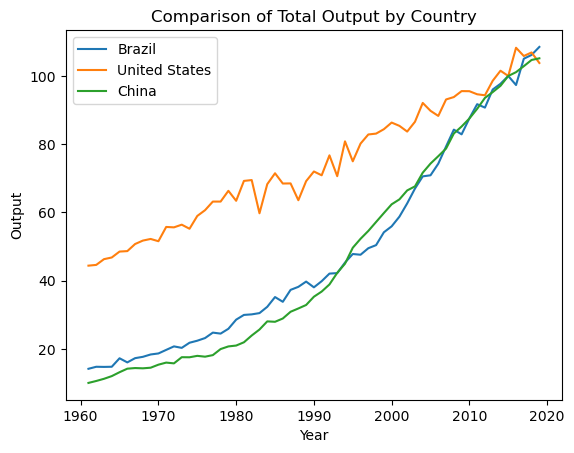

In [20]:
laura.plot_country_output(["Brazil", "United States", "China"])
